### 0. Imports and requirements

In [1]:
!pip install xlstm

Defaulting to user installation because normal site-packages is not writeable


In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
import tqdm

In [2]:
import matplotlib.pyplot as plt
# plt.style.use("seaborn-pastel")

### 1. Data Preprocessing

In [3]:
TRAIN_DATA_PATH = ".../data/train_data/"
TEST_DATA_PATH = ".../data/test_data/"

TRAIN_TARGET_PATH = ".../data/train_target.csv"
TEST_TARGET_PATH = ".../data/test_target.csv"

In [4]:
train_target = pd.read_csv(TRAIN_TARGET_PATH)
train_target

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0


In [5]:
test_target = pd.read_csv(TEST_TARGET_PATH)
test_target

,id
0,3000000
1,3000001
2,3000002
3,3000003
4,3000004
...,...
499995,3499995
499996,3499996
499997,3499997
499998,3499998


In [6]:
import os
import pandas as pd
import tqdm
from typing import List

from dataset_preprocessing_utils import features, transform_credits_to_sequences, create_padded_buckets


def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0, num_parts_to_read: int = 2, 
                                    columns: List[str] = None, verbose: bool = False) -> pd.DataFrame:
    """
    Читает ``num_parts_to_read`` партиций и преобразует их к pandas.DataFrame.

    Параметры:
    -----------
    path_to_dataset: str
        Путь до директории с партициями.
    start_from: int, default=0
        Номер партиции, с которой начать чтение.
    num_parts_to_read: int, default=2
        Число партиций, которые требуется прочитать.
    columns: List[str], default=None
        Список колонок, которые нужно прочитать из каждой партиции. Если None, то считываются все колонки.

    Возвращаемое значение:
    ----------------------
    frame: pandas.DataFrame
        Прочитанные партиции, преобразованные к pandas.DataFrame.
    """

    res = []
    start_from = max(0, start_from)
    # dictionory of format {partition number: partition filename}
    dataset_paths = {int(os.path.splitext(filename)[0].split("_")[-1]): os.path.join(path_to_dataset, filename)
                     for filename in os.listdir(path_to_dataset) if filename != ".ipynb_checkpoints"}
    chunks = [dataset_paths[num] for num in sorted(dataset_paths.keys()) if num>=start_from][:num_parts_to_read]
    
    if verbose:
        print("Reading chunks:", *chunks, sep="\n")
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        chunk = pd.read_parquet(chunk_path, columns=columns)
        res.append(chunk)
    return pd.concat(res).reset_index(drop=True)


* В дальнейшем понадобятся следующие статистики по тренировочной и тестовой выборкам: распределение длин кредитных историй и число уникальных значений каждого категориального значения. Посчитаем эти статистики:

In [7]:
%%time
from collections import defaultdict
import tqdm

train_lens = []
test_lens = []
uniques = defaultdict(set)

for step in tqdm.tqdm(range(0, 12, 4),
                     desc="Count statistics on train data"):
        credits_frame = read_parquet_dataset_from_local(TRAIN_DATA_PATH, step, 4, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        train_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
train_lens = np.hstack(train_lens)

for step in tqdm.tqdm(range(0, 2, 2),
                     desc="Count statistics on test data"):
        credits_frame = read_parquet_dataset_from_local(TEST_DATA_PATH, step, 2, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        test_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
test_lens = np.hstack(test_lens)
uniques = dict(uniques)

Count statistics on train data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
/trinity/home/team08/workspace/data/train_data/train_data_0.pq
/trinity/home/team08/workspace/data/train_data/train_data_1.pq
/trinity/home/team08/workspace/data/train_data/train_data_2.pq
/trinity/home/team08/workspace/data/train_data/train_data_3.pq


/tmp/ipykernel_2480959/1125037625.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on train data:  33%|███▎      | 1/3 [00:04<00:08,  4.02s/it]

Reading chunks:
/trinity/home/team08/workspace/data/train_data/train_data_4.pq
/trinity/home/team08/workspace/data/train_data/train_data_5.pq
/trinity/home/team08/workspace/data/train_data/train_data_6.pq
/trinity/home/team08/workspace/data/train_data/train_data_7.pq


/tmp/ipykernel_2480959/1125037625.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on train data:  67%|██████▋   | 2/3 [00:07<00:03,  3.98s/it]

Reading chunks:
/trinity/home/team08/workspace/data/train_data/train_data_8.pq
/trinity/home/team08/workspace/data/train_data/train_data_9.pq
/trinity/home/team08/workspace/data/train_data/train_data_10.pq
/trinity/home/team08/workspace/data/train_data/train_data_11.pq


/tmp/ipykernel_2480959/1125037625.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on test data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
/trinity/home/team08/workspace/data/test_data/test_data_0.pq
/trinity/home/team08/workspace/data/test_data/test_data_1.pq


/tmp/ipykernel_2480959/1125037625.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Count statistics on test data: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


CPU times: user 32.5 s, sys: 15.2 s, total: 47.7 s
Wall time: 18.5 s


* Чтобы сразу убедиться, что посчитанные статистики интересные и полезные, построим графики распределений длин кредитных историй в тренировочной и тестовой выборках

In [8]:
from collections import Counter


train_len_counter = pd.Series(Counter(train_lens)).sort_index()
test_len_counter = pd.Series(Counter(test_lens)).sort_index()

<BarContainer object of 54 artists>

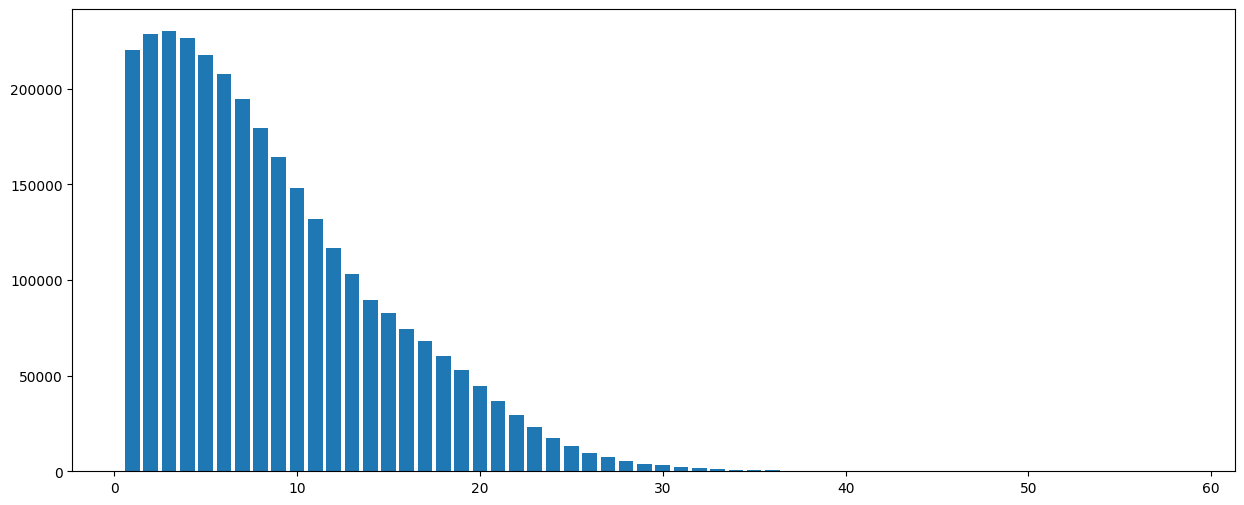

In [9]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(train_len_counter.index.values, train_len_counter.values)

<BarContainer object of 50 artists>

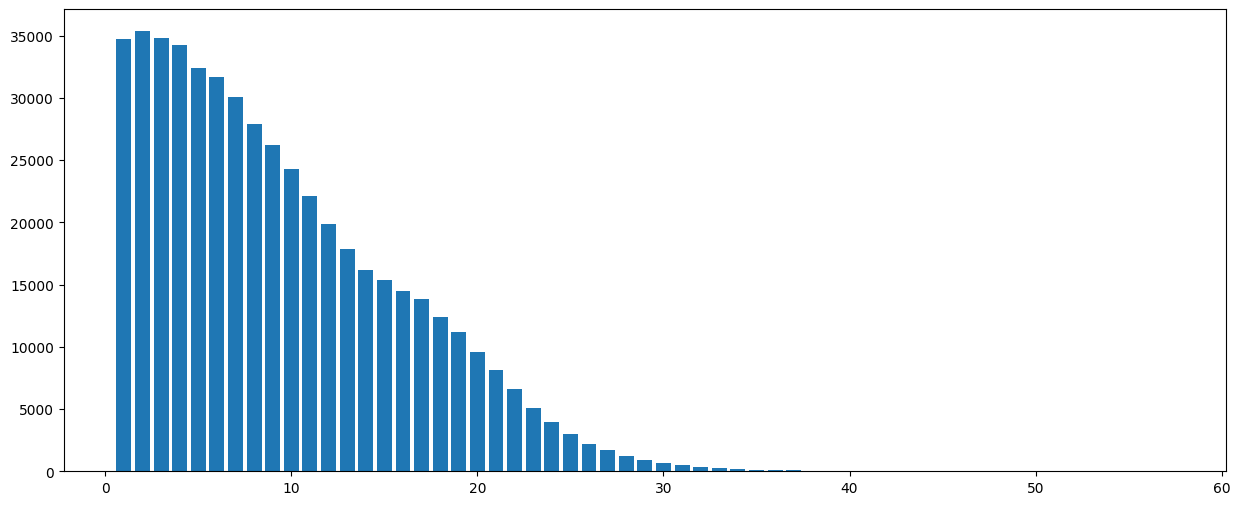

In [10]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(test_len_counter.index.values, test_len_counter.values)

In [11]:
train_lens.max(), test_lens.max()

(58, 57)

* Один из аргументов в функции `dataset_preprocessing_utils.create_padded_buckets` &ndash; `bucket_info` &ndash; словарь, где для конкретной длины последовательности указано до какой длины нужно делать паддинг. Возьмем простое разбиение на 43 бакета: 
| Длина последовательности | Длина после паддинга |
| :-: | :-: 
| 1 &ndash; 40 | без изменений |
| 41 &ndash; 45 | 45 |
| 46 &ndash; 50 | 50 |
| 51 &ndash; 58 | 58 |

In [12]:
keys_ = list(range(1, 59)) 
lens_ = list(range(1, 41)) + [45] * 5 + [50] * 5 + [58] * 8
bucket_info = dict(zip(keys_, lens_))
bucket_info

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 45,
 42: 45,
 43: 45,
 44: 45,
 45: 45,
 46: 50,
 47: 50,
 48: 50,
 49: 50,
 50: 50,
 51: 58,
 52: 58,
 53: 58,
 54: 58,
 55: 58,
 56: 58,
 57: 58,
 58: 58}

* Так же рассмотрим уникальные значения признаков

In [13]:
for feat, uniq in uniques.items():
    print(f"Feature: {feat}, unique values: {uniq}")

Feature: pre_since_opened, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_since_confirmed, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_pterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_fterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_pclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_fclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
Feature: pre_loans_credit_limit, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_loans_next_pay_summ, unique values: {0, 1, 2, 3, 4, 5, 6, 7}
Feature: pre_loans_outstanding, unique values: {1, 2, 3, 4, 5}
Feature: pre_loans_total_overdue, unique values: {0, 1}
Feature: pre_loans_max_overdue_sum, unique values: {0, 1, 2, 3}
Feature: pre_lo

* Поскольку паддинг будет производиться нулями, а категориальные признаки закодированы, начиная с 0, перед паддингом будем сдвигать все значения на 1.

* Вся описанная выше предобработка данных реализована в виде функции `create_buckets_from_credits`:

In [14]:
def create_buckets_from_credits(path_to_dataset, bucket_info, save_to_path, frame_with_ids = None, 
                                num_parts_to_preprocess_at_once: int = 1, 
                                num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Preparing credit data"):
        credits_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=True)
        credits_frame.loc[:, features] += 1       
        seq = transform_credits_to_sequences(credits_frame)
        print("Transforming credits to sequences is done.")
        
        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on="id")

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = "00" + block_as_str
        else:
            block_as_str = "0" + block_as_str
            
        processed_fragment =  create_padded_buckets(seq, bucket_info=bucket_info, has_target=has_target, 
                                                    save_to_file_path=os.path.join(save_to_path, 
                                                                                   f"processed_chunk_{block_as_str}.pkl"))
        block += 1

* Разобьем обучающие данные на тренировочную и валидационную выборки. Воспользуемся самым простым способом &ndash; для валидации случайным образом выберем 10% обучающих данных.

In [15]:
train, val = train_test_split(train_target, random_state=42, test_size=0.1)
train.shape, val.shape

((2700000, 2), (300000, 2))

In [16]:
TRAIN_BUCKETS_PATH = "/trinity/home/team08/workspace/data/train_buckets_rnn"
VAL_BUCKETS_PATH = "/trinity/home/team08/workspace/data/val_buckets_rnn"
TEST_BUCKETS_PATH = "/trinity/home/team08/workspace/data/test_buckets_rnn"

In [17]:
# for buckets_path in [TRAIN_BUCKETS_PATH, VAL_BUCKETS_PATH, TEST_BUCKETS_PATH]:
#     !rm -rf $buckets_path
#     !mkdir $buckets_path

In [18]:
%%time
# create_buckets_from_credits(TRAIN_DATA_PATH,
#                             bucket_info=bucket_info,
#                             save_to_path=TRAIN_BUCKETS_PATH,
#                             frame_with_ids=train,
#                             num_parts_to_preprocess_at_once=4, 
#                             num_parts_total=12, has_target=True)

dataset_train = sorted([
    os.path.join(TRAIN_BUCKETS_PATH, x) 
    for x in os.listdir(TRAIN_BUCKETS_PATH) 
    if os.path.isfile(os.path.join(TRAIN_BUCKETS_PATH, x))  # Ensure it's a file, not a directory
])
dataset_train

CPU times: user 118 µs, sys: 49 µs, total: 167 µs
Wall time: 333 µs


['/trinity/home/team08/workspace/data/train_buckets_rnn/processed_chunk_000.pkl']

In [19]:
%%time
# create_buckets_from_credits(TRAIN_DATA_PATH,
#                             bucket_info=bucket_info,
#                             save_to_path=VAL_BUCKETS_PATH,
#                             frame_with_ids=val,
#                             num_parts_to_preprocess_at_once=4, 
#                             num_parts_total=12, has_target=True)

dataset_val = sorted([
    os.path.join(VAL_BUCKETS_PATH, x) 
    for x in os.listdir(VAL_BUCKETS_PATH) 
    if os.path.isfile(os.path.join(VAL_BUCKETS_PATH, x))  # Ensure it's a file, not a directory
])

dataset_val

CPU times: user 165 µs, sys: 0 ns, total: 165 µs
Wall time: 244 µs


['/trinity/home/team08/workspace/data/val_buckets_rnn/processed_chunk_000.pkl']

In [20]:
%%time
# create_buckets_from_credits(TEST_DATA_PATH,
#                             bucket_info=bucket_info,
#                             save_to_path=TEST_BUCKETS_PATH, num_parts_to_preprocess_at_once=2, 
#                             num_parts_total=2)

dataset_test = sorted([os.path.join(TEST_BUCKETS_PATH, x) for x in os.listdir(TEST_BUCKETS_PATH)])
dataset_test

CPU times: user 78 µs, sys: 32 µs, total: 110 µs
Wall time: 148 µs


['/trinity/home/team08/workspace/data/test_buckets_rnn/processed_chunk_000.pkl']

In [21]:
dataset_train

temp_file_path = '/trinity/home/team08/workspace/data/train_buckets_rnn/processed_chunk_000.pkl'

with open(temp_file_path, 'rb') as file:
    data = pickle.load(file)

len(data['padded_sequences'][23][0][3])

24

In [22]:
data['id'][0][0]

4

### 2. Modeling

In [23]:
import torch

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [25]:
from data_generators import batches_generator
from pytorch_training import eval_model, inference
from training_aux import EarlyStopping

In [26]:
def compute_embed_dim(n_cat: int) -> int:
    return min(600, round(1.6 * n_cat**0.56))

In [27]:
embedding_projections = {feat: (max(uniq)+1, compute_embed_dim(max(uniq)+1)) for feat, uniq in uniques.items()}
embedding_projections

{'pre_since_opened': (20, 9),
 'pre_since_confirmed': (18, 8),
 'pre_pterm': (18, 8),
 'pre_fterm': (17, 8),
 'pre_till_pclose': (17, 8),
 'pre_till_fclose': (16, 8),
 'pre_loans_credit_limit': (20, 9),
 'pre_loans_next_pay_summ': (8, 5),
 'pre_loans_outstanding': (6, 4),
 'pre_loans_total_overdue': (2, 2),
 'pre_loans_max_overdue_sum': (4, 3),
 'pre_loans_credit_cost_rate': (14, 7),
 'pre_loans5': (18, 8),
 'pre_loans530': (20, 9),
 'pre_loans3060': (10, 6),
 'pre_loans6090': (6, 4),
 'pre_loans90': (20, 9),
 'is_zero_loans5': (2, 2),
 'is_zero_loans530': (2, 2),
 'is_zero_loans3060': (2, 2),
 'is_zero_loans6090': (2, 2),
 'is_zero_loans90': (2, 2),
 'pre_util': (20, 9),
 'pre_over2limit': (20, 9),
 'pre_maxover2limit': (20, 9),
 'is_zero_util': (2, 2),
 'is_zero_over2limit': (2, 2),
 'is_zero_maxover2limit': (2, 2),
 'enc_paym_0': (4, 3),
 'enc_paym_1': (4, 3),
 'enc_paym_2': (4, 3),
 'enc_paym_3': (4, 3),
 'enc_paym_4': (4, 3),
 'enc_paym_5': (4, 3),
 'enc_paym_6': (4, 3),
 'enc_pay

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
 
class CausalConv1D(nn.Module):
     def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
         super(CausalConv1D, self).__init__()
         self.padding = (kernel_size - 1) * dilation
         self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)
 
     def forward(self, x):
         x = self.conv(x)
         return x[:, :, :-self.padding]
 
class BlockDiagonal(nn.Module):
     def __init__(self, in_features, out_features, num_blocks):
         super(BlockDiagonal, self).__init__()
         self.in_features = in_features
         self.out_features = out_features
         self.num_blocks = num_blocks
 
         assert in_features % num_blocks == 0
         assert out_features % num_blocks == 0
         
         block_in_features = in_features // num_blocks
         block_out_features = out_features // num_blocks
         
         self.blocks = nn.ModuleList([
             nn.Linear(block_in_features, block_out_features)
             for _ in range(num_blocks)
         ])
         
     def forward(self, x):
         x = x.chunk(self.num_blocks, dim=-1)
         x = [block(x_i) for block, x_i in zip(self.blocks, x)]
         x = torch.cat(x, dim=-1)
         return x
 
class sLSTMBlock(nn.Module):
     def __init__(self, input_size, hidden_size, num_heads, proj_factor=4/3):
         super(sLSTMBlock, self).__init__()
         self.input_size = input_size
         self.hidden_size = hidden_size
         self.num_heads = num_heads
         self.head_size = hidden_size // num_heads
         self.proj_factor = proj_factor
 
         assert hidden_size % num_heads == 0
         assert proj_factor > 0
 
         self.layer_norm = nn.LayerNorm(input_size)
         self.causal_conv = CausalConv1D(1, 1, 4)
 
         self.Wz = BlockDiagonal(input_size, hidden_size, num_heads)
         self.Wi = BlockDiagonal(input_size, hidden_size, num_heads)
         self.Wf = BlockDiagonal(input_size, hidden_size, num_heads)
         self.Wo = BlockDiagonal(input_size, hidden_size, num_heads)
 
         self.Rz = BlockDiagonal(hidden_size, hidden_size, num_heads)
         self.Ri = BlockDiagonal(hidden_size, hidden_size, num_heads)
         self.Rf = BlockDiagonal(hidden_size, hidden_size, num_heads)
         self.Ro = BlockDiagonal(hidden_size, hidden_size, num_heads)
 
         self.group_norm = nn.GroupNorm(num_heads, hidden_size)
 
         self.up_proj_left = nn.Linear(hidden_size, int(hidden_size * proj_factor))
         self.up_proj_right = nn.Linear(hidden_size, int(hidden_size * proj_factor))
         self.down_proj = nn.Linear(int(hidden_size * proj_factor), input_size)
 
     def forward(self, x, prev_state):
         assert x.size(-1) == self.input_size
         h_prev, c_prev, n_prev, m_prev = prev_state
         x_norm = self.layer_norm(x)
         x_conv = F.silu(self.causal_conv(x_norm.unsqueeze(1)).squeeze(1))
 
         z = torch.tanh(self.Wz(x) + self.Rz(h_prev))
         o = torch.sigmoid(self.Wo(x) + self.Ro(h_prev))
         i_tilde = self.Wi(x_conv) + self.Ri(h_prev)
         f_tilde = self.Wf(x_conv) + self.Rf(h_prev)
 
         m_t = torch.max(f_tilde + m_prev, i_tilde)
         i = torch.exp(i_tilde - m_t)
         f = torch.exp(f_tilde + m_prev - m_t)
 
         c_t = f * c_prev + i * z
         n_t = f * n_prev + i
         h_t = o * c_t / n_t
 
         output = h_t
         output_norm = self.group_norm(output)
         output_left = self.up_proj_left(output_norm)
         output_right = self.up_proj_right(output_norm)
         output_gated = F.gelu(output_right)
         output = output_left * output_gated
         output = self.down_proj(output)
         final_output = output + x
 
         return final_output, (h_t, c_t, n_t, m_t)
     
class sLSTM(nn.Module):
     # TODO: Add bias, dropout, bidirectional
     def __init__(self, input_size, hidden_size, num_heads, num_layers=1, batch_first=False, proj_factor=4/3):
         super(sLSTM, self).__init__()
         self.input_size = input_size
         self.hidden_size = hidden_size
         self.num_heads = num_heads
         self.num_layers = num_layers
         self.batch_first = batch_first
         self.proj_factor_slstm = proj_factor
 
         self.layers = nn.ModuleList([sLSTMBlock(input_size, hidden_size, num_heads, proj_factor) for _ in range(num_layers)])
 
     def forward(self, x, state=None):
         assert x.ndim == 3
         if self.batch_first: x = x.transpose(0, 1)
         seq_len, batch_size, _ = x.size()
         
         if state is not None:
             state = torch.stack(list(state))
             assert state.ndim == 4
             num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
             assert num_hidden == 4
             assert state_num_layers == self.num_layers
             assert state_batch_size == batch_size
             assert state_input_size == self.input_size
             state = state.transpose(0, 1)
         else:
             state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size)
 
         output = []
         for t in range(seq_len):
             x_t = x[t]
             for layer in range(self.num_layers):
                 x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                 state[layer] = torch.stack(list(state_tuple))
             output.append(x_t)
         
         output = torch.stack(output)
         if self.batch_first:
             output = output.transpose(0, 1)
         state = tuple(state.transpose(0, 1))
         return output, state
 
class mLSTMBlock(nn.Module):
     def __init__(self, input_size, hidden_size, num_heads, proj_factor=2):
         super(mLSTMBlock, self).__init__()
         self.input_size = input_size
         self.hidden_size = hidden_size
         self.num_heads = num_heads
         self.head_size = hidden_size // num_heads
         self.proj_factor = proj_factor
 
         assert hidden_size % num_heads == 0
         assert proj_factor > 0

         self.layer_norm = nn.LayerNorm(input_size)
         self.up_proj_left = nn.Linear(input_size, int(input_size * proj_factor))
         self.up_proj_right = nn.Linear(input_size, hidden_size)
         self.down_proj = nn.Linear(hidden_size, input_size)
 
         self.causal_conv = CausalConv1D(1, 1, 4)
         self.skip_connection = nn.Linear(int(input_size * proj_factor), hidden_size)
 
         self.Wq = BlockDiagonal(int(input_size * proj_factor), hidden_size, num_heads)
         self.Wk = BlockDiagonal(int(input_size * proj_factor), hidden_size, num_heads)
         self.Wv = BlockDiagonal(int(input_size * proj_factor), hidden_size, num_heads)
         self.Wi = nn.Linear(int(input_size * proj_factor), hidden_size)
         self.Wf = nn.Linear(int(input_size * proj_factor), hidden_size)
         self.Wo = nn.Linear(int(input_size * proj_factor), hidden_size)
 
         self.group_norm = nn.GroupNorm(num_heads, hidden_size)
 
     def forward(self, x, prev_state):
         h_prev, c_prev, n_prev, m_prev = prev_state
         assert x.size(-1) == self.input_size
         x_norm = self.layer_norm(x)
         x_up_left = self.up_proj_left(x_norm)
         x_up_right = self.up_proj_right(x_norm)
 
         x_conv = F.silu(self.causal_conv(x_up_left.unsqueeze(1)).squeeze(1))
         x_skip = self.skip_connection(x_conv)
 
         q = self.Wq(x_conv)
         k = self.Wk(x_conv) / (self.head_size ** 0.5)
         v = self.Wv(x_up_left)
 
         i_tilde = self.Wi(x_conv)
         f_tilde = self.Wf(x_conv)
         o = torch.sigmoid(self.Wo(x_up_left))
 
         m_t = torch.max(f_tilde + m_prev, i_tilde)
         i = torch.exp(i_tilde - m_t)
         f = torch.exp(f_tilde + m_prev - m_t)
 
         c_t = f * c_prev + i * (v * k) # v @ k.T
         n_t = f * n_prev + i * k
         h_t = o * (c_t * q) / torch.max(torch.abs(n_t.T @ q), 1)[0] # o * (c @ q) / max{|n.T @ q|, 1}
 
         output = h_t
         output_norm = self.group_norm(output)
         output = output_norm + x_skip
         output = output * F.silu(x_up_right)
         output = self.down_proj(output)
         final_output = output + x
 
         return final_output, (h_t, c_t, n_t, m_t)
     
class mLSTM(nn.Module):
     # TODO: Add bias, dropout, bidirectional
     def __init__(self, input_size, hidden_size, num_heads, num_layers=1, batch_first=False, proj_factor=2):
         super(mLSTM, self).__init__()
         self.input_size = input_size
         self.hidden_size = hidden_size
         self.num_heads = num_heads
         self.num_layers = num_layers
         self.batch_first = batch_first
         self.proj_factor_slstm = proj_factor
 
         self.layers = nn.ModuleList([mLSTMBlock(input_size, hidden_size, num_heads, proj_factor) for _ in range(num_layers)])
 
     def forward(self, x, state=None):
         assert x.ndim == 3
         if self.batch_first: x = x.transpose(0, 1)
         seq_len, batch_size, _ = x.size()
         
         if state is not None:
             state = torch.stack(list(state))
             assert state.ndim == 4
             num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
             assert num_hidden == 4
             assert state_num_layers == self.num_layers
             assert state_batch_size == batch_size
             assert state_input_size == self.input_size
             state = state.transpose(0, 1)
         else:
             state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size)
 
         output = []
         for t in range(seq_len):
             x_t = x[t]
             for layer in range(self.num_layers):
                 x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                 state[layer] = torch.stack(list(state_tuple))
             output.append(x_t)
         
         output = torch.stack(output)
         if self.batch_first:
             output = output.transpose(0, 1)
         state = tuple(state.transpose(0, 1))
         return output, state
 
class xLSTM(nn.Module):
     # TODO: Add bias, dropout, bidirectional
     def __init__(self, input_size, hidden_size, num_heads, layers, batch_first=False, proj_factor_slstm=4/3, proj_factor_mlstm=2):
         super(xLSTM, self).__init__()
         self.input_size = input_size
         self.hidden_size = hidden_size
         self.num_heads = num_heads
         self.layers = layers
         self.num_layers = len(layers)
         self.batch_first = batch_first
         self.proj_factor_slstm = proj_factor_slstm
         self.proj_factor_mlstm = proj_factor_mlstm
 
         self.layers = nn.ModuleList()
         for layer_type in layers:
             if layer_type == 's':
                 layer = sLSTMBlock(input_size, hidden_size, num_heads, proj_factor_slstm)
             elif layer_type == 'm':
                 layer = mLSTMBlock(input_size, hidden_size, num_heads, proj_factor_mlstm)
             else:
                 raise ValueError(f"Invalid layer type: {layer_type}. Choose 's' for sLSTM or 'm' for mLSTM.")
             self.layers.append(layer)
 
     def forward(self, x, state=None):
         assert x.ndim == 3
         if self.batch_first: x = x.transpose(0, 1)
         seq_len, batch_size, _ = x.size()
         
         if state is not None:
             state = torch.stack(list(state))
             assert state.ndim == 4
             num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
             assert num_hidden == 4
             assert state_num_layers == self.num_layers
             assert state_batch_size == batch_size
             assert state_input_size == self.input_size
             state = state.transpose(0, 1)
         else:
             state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size)
 
         output = []
         for t in range(seq_len):
             x_t = x[t]
             for layer in range(self.num_layers):
                 x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                 state[layer] = torch.stack(list(state_tuple))
             output.append(x_t)
         
         output = torch.stack(output)
         if self.batch_first:
             output = output.transpose(0, 1)

         state = tuple(state.transpose(0, 1))
         
         return output, state


In [31]:
class CreditsxLSTM(nn.Module):
    def __init__(self, features, embedding_projections, hidden_size=258, num_heads=6, layers=['s', 'm', 's'], proj_factor_slstm=4/3, proj_factor_mlstm=2):
        super(CreditsxLSTM, self).__init__()
        self.embedding_projections = nn.ModuleList([self._create_embedding_projection(*embedding_projections[feature]) for feature in features])
        self.input_size = sum([embedding_projections[feature][1] for feature in features])
        self.xlstm = xLSTM(input_size=self.input_size, hidden_size=hidden_size, num_heads=num_heads, layers=layers, proj_factor_slstm=proj_factor_slstm, proj_factor_mlstm=proj_factor_mlstm, batch_first=True)
        self.hidden_size = hidden_size
        self.top_classifier = nn.Linear(hidden_size, 32)
        self.intermediate_activation = nn.ReLU()
        self.head = nn.Linear(32, 1)

    def forward(self, features):
        device = next(self.parameters()).device  # Get the device of the model's parameters
        batch_size = features[0].shape[0]
        
        # Ensure features are on the same device as the model
        embeddings = [embedding(features[i].to(device)) for i, embedding in enumerate(self.embedding_projections)]
        concated_embeddings = torch.cat(embeddings, dim=-1)

        output, last_hidden = self.xlstm(concated_embeddings)
        last_hidden_mean = torch.mean(last_hidden[-1], dim=0, keepdim=True)

        last_hidden_mean = torch.reshape(last_hidden_mean.permute(1, 2, 0), shape=(batch_size, self.hidden_size))
        
        classification_hidden = self.top_classifier(last_hidden_mean)
        activation = self.intermediate_activation(classification_hidden)
        raw_output = self.head(activation)
        
        return raw_output

    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality + add_missing, embedding_dim=embed_size, padding_idx=padding_idx)


In [32]:
import torch.optim as optim

learning_rate = 0.001

model = CreditsxLSTM(features, embedding_projections)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10
train_batch_size = 128
val_batch_size = 128

In [33]:
from tqdm import tqdm_notebook

def train_epoch(model: torch.nn.Module, optimizer: torch.optim.Optimizer, dataset_train: List[str],
                batch_size: int = 64, shuffle: bool = True, print_loss_every_n_batches: int = 500,
                device: torch.device = None):

    model.train()
    loss_function = nn.BCEWithLogitsLoss(reduction="none")
    losses = torch.Tensor().to(device)
    samples_counter = 0
    train_generator = batches_generator(dataset_train, batch_size=batch_size, shuffle=shuffle, device=device, is_train=True, output_format="torch")

    for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):
        # Ensure the model, features, and labels are on the same device
        features = [feature.to(device) for feature in batch["features"]]
        labels = batch["label"].float().to(device)
        
        # Forward pass
        output = torch.flatten(model(features))

        # Compute loss
        batch_loss = loss_function(output.to(device), labels.to(device))
        batch_loss.mean().backward()
        optimizer.step()
        optimizer.zero_grad()

        samples_counter += batch_loss.size(0)

        losses = torch.cat([losses, batch_loss], dim=0)
        if num_batch % print_loss_every_n_batches == 0:
            print(f"Batches {num_batch - print_loss_every_n_batches + 1} - {num_batch} loss:"
                  f"{losses[-samples_counter:].mean().item()}", end="\r")
            samples_counter = 0
        if num_batch % 10 == 0:
            print("Batch: ", num_batch)

        if num_batch == 780:
            break




In [34]:
device

device(type='cuda')

In [35]:
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}")
    train_epoch(model, optimizer, dataset_train, batch_size=train_batch_size, 
                shuffle=True, print_loss_every_n_batches=500, device=device)

    print("Next step")

    
    # Оценка модели на валидационных данных
    val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_size, device=device)
    
    # Сохранение модели по результатам валидации
    torch.save(model.state_dict(), f"epoch_{epoch+1}_val_{val_roc_auc:.3f}.pt")
    print(f"Epoch {epoch+1} completed. Validation ROC AUC: {val_roc_auc:.4f}")
    

Starting epoch 1


/tmp/ipykernel_2480959/909155273.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):


Training: 0it [00:00, ?it/s]

Batch:  10
Batch:  20
Batch:  30
Batch:  40
Batch:  50
Batch:  60
Batch:  70
Batch:  80
Batch:  90
Batch:  100
Batch:  110
Batch:  120
Batch:  130
Batch:  140
Batch:  150
Batch:  160
Batch:  170
Batch:  180
Batch:  190
Batch:  200
Batch:  210
Batch:  220
Batch:  230
Batch:  240
Batch:  250
Batch:  260
Batch:  270
Batch:  280
Batch:  290
Batch:  300
Batch:  310
Batch:  320
Batch:  330
Batch:  340
Batch:  350
Batch:  360
Batch:  370
Batch:  380
Batch:  390
Batch:  400
Batch:  410
Batch:  420
Batch:  430
Batch:  440
Batch:  450
Batch:  460
Batch:  470
Batch:  480
Batch:  490
Batch:  500 500 loss:0.1266031712293625
Batch:  510
Batch:  520
Batch:  530
Batch:  540
Batch:  550
Batch:  560
Batch:  570
Batch:  580
Batch:  590
Batch:  600
Batch:  610
Batch:  620
Batch:  630
Batch:  640
Batch:  650
Batch:  660
Batch:  670
Batch:  680
Batch:  690
Batch:  700
Batch:  710
Batch:  720
Batch:  730
Batch:  740
Batch:  750
Batch:  760
Batch:  770
Batch:  780
Next step


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Validation ROC AUC: 0.6633
Starting epoch 2


/tmp/ipykernel_2480959/909155273.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):


Training: 0it [00:00, ?it/s]

Batch:  10
Batch:  20
Batch:  30
Batch:  40
Batch:  50
Batch:  60
Batch:  70
Batch:  80
Batch:  90
Batch:  100
Batch:  110
Batch:  120
Batch:  130
Batch:  140
Batch:  150
Batch:  160
Batch:  170
Batch:  180
Batch:  190
Batch:  200
Batch:  210
Batch:  220
Batch:  230
Batch:  240
Batch:  250
Batch:  260
Batch:  270
Batch:  280
Batch:  290
Batch:  300
Batch:  310
Batch:  320
Batch:  330
Batch:  340
Batch:  350
Batch:  360
Batch:  370
Batch:  380
Batch:  390
Batch:  400
Batch:  410
Batch:  420
Batch:  430
Batch:  440
Batch:  450
Batch:  460
Batch:  470
Batch:  480
Batch:  490
Batch:  500 500 loss:0.18795642256736755
Batch:  510
Batch:  520
Batch:  530
Batch:  540
Batch:  550
Batch:  560
Batch:  570
Batch:  580
Batch:  590
Batch:  600
Batch:  610
Batch:  620
Batch:  630
Batch:  640
Batch:  650
Batch:  660
Batch:  670
Batch:  680
Batch:  690
Batch:  700
Batch:  710
Batch:  720
Batch:  730
Batch:  740
Batch:  750
Batch:  760
Batch:  770
Batch:  780
Next step


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Validation ROC AUC: 0.7291
Starting epoch 3


/tmp/ipykernel_2480959/909155273.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):


Training: 0it [00:00, ?it/s]

Batch:  10
Batch:  20
Batch:  30
Batch:  40
Batch:  50
Batch:  60
Batch:  70
Batch:  80
Batch:  90
Batch:  100
Batch:  110
Batch:  120
Batch:  130
Batch:  140
Batch:  150
Batch:  160
Batch:  170
Batch:  180
Batch:  190
Batch:  200
Batch:  210
Batch:  220
Batch:  230
Batch:  240
Batch:  250
Batch:  260
Batch:  270
Batch:  280
Batch:  290
Batch:  300
Batch:  310
Batch:  320
Batch:  330
Batch:  340
Batch:  350
Batch:  360
Batch:  370
Batch:  380
Batch:  390
Batch:  400
Batch:  410
Batch:  420
Batch:  430
Batch:  440
Batch:  450
Batch:  460
Batch:  470
Batch:  480
Batch:  490
Batch:  500 500 loss:0.11287154257297516
Batch:  510
Batch:  520
Batch:  530
Batch:  540
Batch:  550
Batch:  560
Batch:  570
Batch:  580
Batch:  590
Batch:  600
Batch:  610
Batch:  620
Batch:  630
Batch:  640
Batch:  650
Batch:  660
Batch:  670
Batch:  680
Batch:  690
Batch:  700
Batch:  710
Batch:  720
Batch:  730
Batch:  740
Batch:  750
Batch:  760
Batch:  770
Batch:  780
Next step


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Validation ROC AUC: 0.7223
Starting epoch 4


/tmp/ipykernel_2480959/909155273.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):


Training: 0it [00:00, ?it/s]

Batch:  10
Batch:  20
Batch:  30
Batch:  40
Batch:  50
Batch:  60
Batch:  70
Batch:  80
Batch:  90
Batch:  100
Batch:  110
Batch:  120
Batch:  130
Batch:  140
Batch:  150
Batch:  160
Batch:  170
Batch:  180
Batch:  190
Batch:  200
Batch:  210
Batch:  220
Batch:  230
Batch:  240
Batch:  250
Batch:  260
Batch:  270
Batch:  280
Batch:  290
Batch:  300
Batch:  310
Batch:  320
Batch:  330
Batch:  340
Batch:  350
Batch:  360
Batch:  370
Batch:  380
Batch:  390
Batch:  400
Batch:  410
Batch:  420
Batch:  430
Batch:  440
Batch:  450
Batch:  460
Batch:  470
Batch:  480
Batch:  490
Batch:  500 500 loss:0.12739212810993195
Batch:  510
Batch:  520
Batch:  530
Batch:  540
Batch:  550
Batch:  560
Batch:  570
Batch:  580
Batch:  590
Batch:  600
Batch:  610
Batch:  620
Batch:  630
Batch:  640
Batch:  650
Batch:  660
Batch:  670
Batch:  680
Batch:  690
Batch:  700
Batch:  710
Batch:  720
Batch:  730
Batch:  740
Batch:  750
Batch:  760
Batch:  770
Batch:  780
Next step


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Validation ROC AUC: 0.7499
Starting epoch 5


/tmp/ipykernel_2480959/909155273.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):


Training: 0it [00:00, ?it/s]

Batch:  10
Batch:  20
Batch:  30
Batch:  40
Batch:  50
Batch:  60
Batch:  70
Batch:  80
Batch:  90
Batch:  100
Batch:  110
Batch:  120
Batch:  130
Batch:  140
Batch:  150
Batch:  160
Batch:  170
Batch:  180
Batch:  190
Batch:  200
Batch:  210
Batch:  220
Batch:  230
Batch:  240
Batch:  250
Batch:  260
Batch:  270
Batch:  280
Batch:  290
Batch:  300
Batch:  310
Batch:  320
Batch:  330
Batch:  340
Batch:  350
Batch:  360
Batch:  370
Batch:  380
Batch:  390
Batch:  400
Batch:  410
Batch:  420
Batch:  430
Batch:  440
Batch:  450
Batch:  460
Batch:  470
Batch:  480
Batch:  490
Batch:  500 500 loss:0.14468777179718018
Batch:  510
Batch:  520
Batch:  530
Batch:  540
Batch:  550
Batch:  560
Batch:  570
Batch:  580
Batch:  590
Batch:  600
Batch:  610
Batch:  620
Batch:  630
Batch:  640
Batch:  650
Batch:  660
Batch:  670
Batch:  680
Batch:  690
Batch:  700
Batch:  710
Batch:  720
Batch:  730
Batch:  740
Batch:  750
Batch:  760
Batch:  770
Batch:  780
Next step


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Validation ROC AUC: 0.7454
Starting epoch 6


/tmp/ipykernel_2480959/909155273.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):


Training: 0it [00:00, ?it/s]

Batch:  10
Batch:  20
Batch:  30
Batch:  40
Batch:  50
Batch:  60
Batch:  70
Batch:  80
Batch:  90
Epoch 6 completed. Validation ROC AUC: 0.7364
Starting epoch 7


/tmp/ipykernel_2480959/909155273.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):


Training: 0it [00:00, ?it/s]

Batch:  10
Batch:  20
Batch:  30
Batch:  40
Batch:  50
Batch:  60
Batch:  70
Batch:  80
Batch:  90
Batch:  100
Batch:  110
Batch:  120
Batch:  130
Batch:  140
Batch:  150
Batch:  160
Batch:  170
Batch:  180
Batch:  190
Batch:  200
Batch:  210
Batch:  220
Batch:  230
Batch:  240
Batch:  250
Batch:  260
Batch:  270
Batch:  280
Batch:  290
Batch:  300
Batch:  310
Batch:  320
Batch:  330
Batch:  340
Batch:  350
Batch:  360
Batch:  370
Batch:  380
Batch:  390
Batch:  400
Batch:  410
Batch:  420
Batch:  430
Batch:  440
Batch:  450
Batch:  460
Batch:  470
Batch:  480
Batch:  490
Batch:  500 500 loss:0.11975815892219543
Batch:  510
Batch:  520
Batch:  530
Batch:  540
Batch:  550
Batch:  560
Batch:  570
Batch:  580
Batch:  590
Batch:  600
Batch:  610
Batch:  620
Batch:  630
Batch:  640
Batch:  650
Batch:  660
Batch:  670
Batch:  680
Batch:  690
Batch:  700
Batch:  710
Batch:  720
Batch:  730
Batch:  740
Batch:  750
Batch:  760
Batch:  770
Batch:  780
Next step


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Validation ROC AUC: 0.7603
Starting epoch 8


/tmp/ipykernel_2480959/909155273.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):


Training: 0it [00:00, ?it/s]

Batch:  10
Batch:  20
Batch:  30
Batch:  40
Batch:  50
Batch:  60
Batch:  70
Batch:  80
Batch:  90
Batch:  100
Batch:  110
Batch:  120
Batch:  130
Batch:  140
Batch:  150
Batch:  160
Batch:  170
Batch:  180
Batch:  190
Batch:  200
Batch:  210
Batch:  220
Batch:  230
Batch:  240
Batch:  250
Batch:  260
Batch:  270
Batch:  280
Batch:  750
Batch:  760
Batch:  770
Batch:  780
Next step


Evaluating model: 0it [00:00, ?it/s]

Epoch 8 completed. Validation ROC AUC: 0.7543
Starting epoch 9


/tmp/ipykernel_2480959/909155273.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):


Training: 0it [00:00, ?it/s]

Batch:  10
Batch:  20
Batch:  30
Batch:  40
Batch:  50
Batch:  60
Batch:  70
Batch:  80
Batch:  90
Batch:  100
Batch:  110
Batch:  120
Batch:  130
Batch:  140
Batch:  150
Batch:  160
Batch:  170
Batch:  180
Batch:  190
Batch:  200
Batch:  210
Batch:  220
Batch:  230
Batch:  240
Batch:  250
Batch:  260
Batch:  270
Batch:  280
Batch:  290
Batch:  300
Batch:  310
Batch:  320
Batch:  330
Batch:  340
Batch:  350
Batch:  360
Batch:  370
Batch:  380
Batch:  390
Batch:  400
Batch:  410
Batch:  420
Batch:  430
Batch:  440
Batch:  450
Batch:  460
Batch:  470
Batch:  480
Batch:  490
Batch:  500 500 loss:0.13187247514724731
Batch:  510
Batch:  520
Batch:  530
Batch:  540
Batch:  550
Batch:  560
Batch:  570
Batch:  580
Batch:  590
Batch:  600
Batch:  610
Batch:  620
Batch:  630
Batch:  640
Batch:  650
Batch:  660
Batch:  670
Batch:  680
Batch:  690
Batch:  700
Batch:  710
Batch:  720
Batch:  730
Batch:  740
Batch:  750
Batch:  760
Batch:  770
Batch:  780
Next step


Evaluating model: 0it [00:00, ?it/s]

Epoch 9 completed. Validation ROC AUC: 0.7444
Starting epoch 10


/tmp/ipykernel_2480959/909155273.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):


Training: 0it [00:00, ?it/s]

Batch:  10
Batch:  20
Batch:  30
Batch:  40
Batch:  50
Batch:  60
Batch:  70
Batch:  80
Batch:  90
Batch:  100
Batch:  110
Batch:  120
Batch:  130
Batch:  140
Batch:  150
Batch:  160
Batch:  170
Batch:  180
Batch:  190
Batch:  200
Batch:  210
Batch:  220
Batch:  230
Batch:  240
Batch:  250
Batch:  260
Batch:  270
Batch:  280
Batch:  290
Batch:  300
Batch:  310
Batch:  320
Batch:  330
Batch:  340
Batch:  350
Batch:  360
Batch:  370
Batch:  380
Batch:  390
Batch:  400
Batch:  410
Batch:  420
Batch:  430
Batch:  440
Batch:  450
Batch:  460
Batch:  470
Batch:  480
Batch:  490
Batch:  500 500 loss:0.12298358976840973
Batch:  510
Batch:  520
Batch:  530
Batch:  540
Batch:  550
Batch:  560
Batch:  570
Batch:  580
Batch:  590
Batch:  600
Batch:  610
Batch:  620
Batch:  630
Batch:  640
Batch:  650
Batch:  660
Batch:  670
Batch:  680
Batch:  690
Batch:  700
Batch:  710
Batch:  720
Batch:  730
Batch:  740
Batch:  750
Batch:  760
Batch:  770
Batch:  780
Next step


Evaluating model: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### 3. Training

In [ ]:
!rm -r .../main_project/./checkpoints/
!mkdir .../main_project/./checkpoints/

!rm -r .../main_project/./checkpoints/pytorch_baseline
!mkdir .../main_project/./checkpoints/pytorch_baseline

* Для того, чтобы детектировать переобучение используем EarlyStopping.

In [ ]:
path_to_checkpoints = "/trinity/home/team08/workspace/data/./checkpoints/pytorch_baseline/"
es = EarlyStopping(patience=3, mode="max", verbose=True, save_path=os.path.join(path_to_checkpoints, "best_checkpoint.pt"), 
                   metric_name="ROC-AUC", save_format="torch")

In [10]:
# %%time
# for epoch in range(num_epochs):
#     print(f"Starting epoch {epoch+1}")
#     train_epoch(model, optimizer, dataset_train, batch_size=train_batch_size, 
#                 shuffle=True, print_loss_every_n_batches=500, device=device)
    
#     val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_size, device=device)
#     es(val_roc_auc, model)
    
#     if es.early_stop:
#         print("Early stopping reached. Stop training...")
#         break
#     torch.save(model.state_dict(), os.path.join(path_to_checkpoints, f"epoch_{epoch+1}_val_{val_roc_auc:.3f}.pt"))
    
#     train_roc_auc = eval_model(model, dataset_train, batch_size=val_batch_size, device=device)
#     print(f"Epoch {epoch+1} completed. Train ROC AUC: {train_roc_auc}, val ROC AUC: {val_roc_auc}")

### 4. Submission

* Подготовим посылку в проверяющую систему

In [2]:
# path_to_checkpoints

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [3]:
# model.load_state_dict(torch.load(os.path.join(path_to_checkpoints, "best_checkpoint.pt"), map_location=torch.device('cpu')))

In [4]:
# model.load_state_dict(torch.load(os.path.join(path_to_checkpoints, "best_checkpoint.pt")))

In [5]:
# test_preds = inference(model, dataset_test, batch_size=128, device=device)

In [6]:
# train_preds = inference(model, dataset_train, batch_size=128, device=device)
# train_preds

In [7]:
# pd.Series(train_preds.score, dtype='int64')

In [8]:
# train_preds.score.max()

In [9]:
# train_target[:2700000].flag

In [29]:
# class CreditsxLSTM(nn.Module):
#     def __init__(self, features, embedding_projections, hidden_size=258, num_heads=6, layers=['s', 'm', 's'], proj_factor_slstm=4/3, proj_factor_mlstm=2):
#         super(CreditsxLSTM, self).__init__()
#         self.embedding_projections = nn.ModuleList([self._create_embedding_projection(*embedding_projections[feature]) for feature in features])
#         self.input_size = sum([embedding_projections[feature][1] for feature in features])
#         print(self.input_size)
#         self.xlstm = xLSTM(input_size=self.input_size, hidden_size=hidden_size, num_heads=num_heads, layers=layers, proj_factor_slstm=proj_factor_slstm, proj_factor_mlstm=proj_factor_mlstm, batch_first=True)
#         self.hidden_size = hidden_size
#         self.top_classifier = nn.Linear(hidden_size, 32)
#         self.intermediate_activation = nn.ReLU()
#         self.head = nn.Linear(32, 1)

#     def forward(self, features):
#         batch_size = features[0].shape[0]
#         embeddings = [embedding(features[i]) for i, embedding in enumerate(self.embedding_projections)]
#         concated_embeddings = torch.cat(embeddings, dim=-1)


#         output, last_hidden = self.xlstm(concated_embeddings)
#         #last_hidden = state[-1]
#         #last_hidden = last_hidden[0]


#         last_hidden_mean = torch.mean(last_hidden[-1], dim=0, keepdim=True)  # Теперь last_hidden_mean имеет размерность (1, 128, 258)


        
#         last_hidden_mean = torch.reshape(last_hidden_mean.permute(1, 2, 0), shape=(batch_size, self.hidden_size))
        
#         classification_hidden = self.top_classifier(last_hidden_mean)
#         activation = self.intermediate_activation(classification_hidden)
#         raw_output = self.head(activation)
#         return raw_output

#     @classmethod
#     def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
#         add_missing = 1 if add_missing else 0
#         return nn.Embedding(num_embeddings=cardinality + add_missing, embedding_dim=embed_size, padding_idx=padding_idx)